In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
model = keras.models.load_model('../models/linear_from_scratch_with_augmentation.h5')

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 146, 24)      1824      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 36)        21636     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 36)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 48)        43248     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        2

In [5]:
val_df = pd.read_csv("../data/val.csv", index_col=0)
val_df['id'] = val_df.index
val_df['id'] = val_df['id'].apply(lambda x: x+".jpg")
val_df.head()

,dist_0,ABS_RX,ABS_Y,id
2020-06-16_08-53-24-362221,242.32,0.0,0.0,2020-06-16_08-53-24-362221.jpg
2020-06-16_08-53-25-504531,241.55,0.0,0.2,2020-06-16_08-53-25-504531.jpg
2020-06-16_08-53-26-657194,183.66,0.0,0.5,2020-06-16_08-53-26-657194.jpg
2020-06-16_08-53-27-807611,121.49,0.0,0.5,2020-06-16_08-53-27-807611.jpg
2020-06-16_08-53-28-958042,112.80,-1.0,0.5,2020-06-16_08-53-28-958042.jpg


In [6]:
images = []
y_true = []

for i in val_df.index:
    img = image.load_img(f"../data/val/{i}.jpg", target_size=(150, 150))
    x = image.img_to_array(img)
    images.append(x)
    
    y_true.append(val_df.loc[i, "ABS_RX"])

images = np.asarray(images)
y_true = np.asarray(y_true)

In [7]:
images = images/255

In [8]:
images.shape

(300, 150, 150, 3)

In [10]:
preds = model.predict(images)

In [196]:
# Select a picture

nr = 4

In [197]:
img = images[nr]
pred = preds[nr]
pred

array([-0.56514794], dtype=float32)

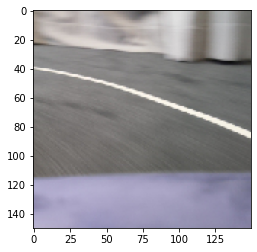

In [198]:
plt.imshow(img)

In [199]:
img = np.expand_dims(img, axis=0)

In [200]:
img.shape

(1, 150, 150, 3)

In [201]:
# Visualization using grad-CAM (does this make sense on regression...?)

last_conv_layer = model.get_layer("conv2d_4")
grads = tf.GradientTape(pred, last_conv_layer.output)

gradModel = models.Model(inputs=[model.inputs], outputs=[last_conv_layer.output, model.output])

with tf.GradientTape() as tape:
    inputs = tf.cast(img, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions
grads = tape.gradient(loss, convOutputs)

castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads
convOutputs = convOutputs[0]
guidedGrads = guidedGrads[0]

weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
heatmap = cv2.resize(cam.numpy(), (150, 150))
numer = heatmap - np.min(heatmap)
denom = (heatmap.max() - heatmap.min()) + 1e-8
heatmap = numer / denom
heatmap = (heatmap * 255).astype("uint8")

In [202]:
heatmap.shape

(150, 150)

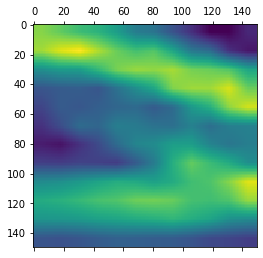

In [203]:
plt.matshow(heatmap)

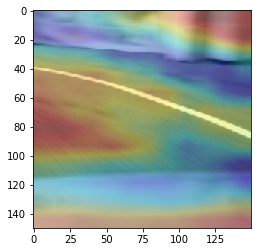

In [209]:
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img=heatmap/255*0.3 + img[0] *0.7
plt.imshow(superimposed_img)